# Automatic_outlier_detection
Reference: <br>
https://datachemeng.com/ensembleoutliersampledetection/ <br>
https://datachemeng.com/outlier_samples_detectionc_python/ <br>
https://datachemeng.com/partialleastsquares/ <br>
https://github.com/hkaneko1985/ensemble_outlier_sample_detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

In [2]:
# Load the dataset
file_name = 'glass'      # Give without ".csv"
dataset = pd.read_csv(file_name + '.csv')
dataset.head()

,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
x = dataset.iloc[:, 2:10]
y = dataset.iloc[:,1]

In [4]:
print(x.shape)
x.head()

(214, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [5]:
y.head()

0    1.52101
1    1.51761
2    1.51618
3    1.51766
4    1.51742
Name: RI, dtype: float64

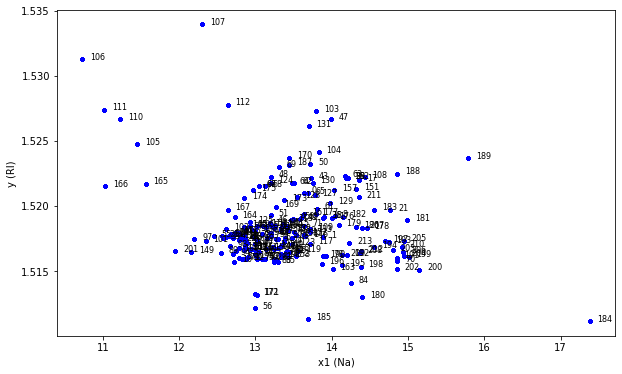

In [6]:
# See the data
plt.figure(figsize = (10, 6))
for (i, j, k) in zip(x.iloc[:, 0], y, x.index):
    plt.scatter(x.iloc[:, 0], y, marker = '.', c = 'b')
    plt.annotate(k, xy=(i + 0.1, j), fontsize = 8)
    
plt.xlabel('x1 (Na)')
plt.ylabel('y (RI)')
plt.show()

### Outlier detection by partial least square (PLS) method

In [7]:
# Set the parameters
number_of_submodels = 100                     # Number of submodels
max_iteration_number = 20                     # Number of iteration
fold_number = 5                               # Number of folds in cross varidation
max_number_of_principal_components = 50       # Max number of principal components

In [8]:
# Initialization
outlier_sample_flags = ~(y == y)               # Set all flags False
previous_outlier_sample_flags = ~(y == y)      # Set all flags False

In [9]:
# Auto-scaling function
def auto_scale(data_frame):
    return (data_frame - data_frame.mean()) / data_frame.std()

In [10]:
computation_num = []
all_R2 = []
cnt = 0

print('Iteration\tSample number that matches outliers')
print('=' * 52)
np.random.seed(1)

for iteration_number in range(max_iteration_number):
    
    normal_x = x[~outlier_sample_flags]         # Select raws that are not assigned as outliers
    normal_y = y[~outlier_sample_flags]         # initially all are "False" = "not outlier"
        
    estimated_y_all = pd.DataFrame()            # Make blank DataFrame to fill in estimated y for submodels
    
    for submodel_number in range(number_of_submodels):
        m = len(normal_x)
        selected_sample_numbers = np.floor(np.random.rand(m) * m)       # Select raw number of x randomly

        selected_x = normal_x.iloc[selected_sample_numbers, :]
        selected_y = normal_y.iloc[selected_sample_numbers]
        unique_number, unique_index = np.unique(selected_sample_numbers, return_index=True)
        
        std_0_variable_flags = selected_x.std() == 0          # Remove x when stdev = 0 to make computation feasible
        new_selected_x = selected_x.drop(selected_x.columns[std_0_variable_flags], axis=1)
        new_x = x.drop(x.columns[std_0_variable_flags], axis=1)
        
        # Auto-scaling
        selected_autoscaled_x = auto_scale(new_selected_x)
        autoscaled_x = (new_x - new_selected_x.mean()) / new_selected_x.std()
        selected_autoscaled_y = auto_scale(selected_y)
        
        # Make predicted y matrix
        components = []
        r2_in_cv_all = []
        
        for component in range(1, min(np.linalg.matrix_rank(selected_autoscaled_x), max_number_of_principal_components) + 1):

            submodel_f_in_cv  = PLSRegression(n_components = component)                   # PLS model defined by "component"
            estimated_y_in_cv = pd.DataFrame(cross_val_predict(estimator = submodel_f_in_cv,
                                                               X = selected_autoscaled_x,
                                                               y = selected_autoscaled_y,
                                                               cv = fold_number))         # estimate y in cv
            estimated_y_in_cv = estimated_y_in_cv * selected_y.std() + selected_y.mean()  # back from auto-scaling
            r2_in_cv = metrics.r2_score(selected_y, estimated_y_in_cv)                    # compute R2
            
            components.append(component)
            r2_in_cv_all.append(r2_in_cv)
            
            cnt += 1
            computation_num.append(cnt)
            all_R2.append(r2_in_cv)
        
        optimal_component_number = components[r2_in_cv_all.index(max(r2_in_cv_all))]      # choose the best component number
        best_submodel = PLSRegression(n_components = optimal_component_number)            # PLS model by the best "component"

        best_submodel.fit(selected_autoscaled_x, selected_autoscaled_y)                   # make the best submodel
        estimated_y = pd.DataFrame(best_submodel.predict(autoscaled_x))                   # predict y by the best submodel
        estimated_y = estimated_y * selected_y.std() + selected_y.mean()                  # back from auto-scaling
        estimated_y_all = pd.concat([estimated_y_all, estimated_y], axis=1)
        
    estimated_y_all.index = y.index
    
    # Find outliers
    estimated_y_all_normal = estimated_y_all[~outlier_sample_flags]
    estimated_y_median_normal = estimated_y_all_normal.median(axis = 1)
    estimated_y_mad_normal = np.median(abs(estimated_y_all_normal - np.median(estimated_y_median_normal)))
    y_error = abs(y - estimated_y_all.median(axis=1))
    outlier_sample_flags = y_error > 3 * 1.4826 * estimated_y_mad_normal
    
    print(iteration_number, '             ', sum(outlier_sample_flags == previous_outlier_sample_flags))
    
    if sum(outlier_sample_flags == previous_outlier_sample_flags) == len(x):
        print('=' * 52)
        print('DONE: all outliers are matched.')
        break
        
    previous_outlier_sample_flags = outlier_sample_flags.copy()

Iteration	Sample number that matches outliers
0               213
1               214
DONE: all outliers are matched.


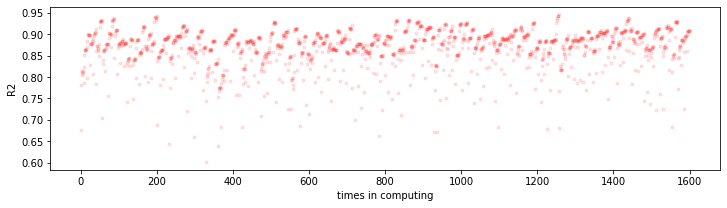

In [11]:
# See R2 trend during computation
plt.figure(figsize = (12, 3))
plt.scatter(computation_num, all_R2, marker = '.', c = 'r', alpha = 0.1)
plt.xlabel('times in computing')
plt.ylabel('R2')
plt.show()

In [12]:
# See flags for all samples
outlier_sample_flags = pd.DataFrame(outlier_sample_flags)
outlier_sample_flags.columns = ['TRUE if outlier samples']
outlier_sample_flags.to_csv('outlier_sample_detection_results_pls.csv')

print(outlier_sample_flags.shape)
outlier_sample_flags.head()

(214, 1)


,TRUE if outlier samples
0,False
1,False
2,False
3,False
4,False


In [13]:
# See non-outlier samples
sample_selected = outlier_sample_flags[outlier_sample_flags['TRUE if outlier samples'] == False]
print('Number of all data          ', len(x))
print('Number of non-outlier data  ', len(sample_selected))
sample_selected.head()

Number of all data           214
Number of non-outlier data   213


,TRUE if outlier samples
0,False
1,False
2,False
3,False
4,False


In [14]:
# Save non-outlier dataset as DataFrame
flag_x = sample_selected.join(x, how='inner')
flag_y = sample_selected.join(y, how='inner')
flag_xy = flag_x.join(y, how='inner')
xy_non_outlier = flag_xy.drop('TRUE if outlier samples', axis=1)
xy_non_outlier.to_csv(file_name + '_removed_outlier.csv', index = False)

print(xy_non_outlier.shape)
xy_non_outlier.head()

(213, 9)


,Na,Mg,Al,Si,K,Ca,Ba,Fe,RI
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1.52101
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1.51761
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1.51618
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1.51766
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1.51742


In [15]:
# See outlier samples
sample_outlier = outlier_sample_flags[outlier_sample_flags['TRUE if outlier samples'] == True]
print('Number of all data      ', len(x))
print('Number of outlier data  ', len(sample_outlier))

flag_xo = sample_outlier.join(x, how='inner')
flag_yo = sample_outlier.join(y, how='inner')
flag_xyo = flag_xo.join(y, how='inner')
xy_outlier = flag_xyo.drop('TRUE if outlier samples', axis=1)

print(xy_outlier.shape)
xy_outlier.head()

Number of all data       214
Number of outlier data   1
(1, 9)


,Na,Mg,Al,Si,K,Ca,Ba,Fe,RI
56,12.99,3.47,1.12,72.98,0.62,8.35,0.0,0.31,1.51215


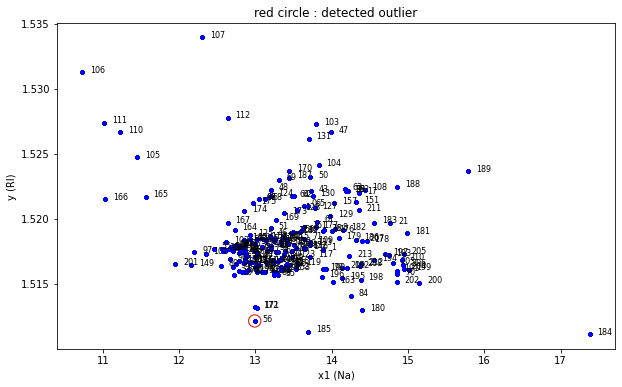

In [16]:
# See the data without outliers
plt.figure(figsize = (10, 6))
for (i, j, k) in zip(x.iloc[:, 0], y, x.index):
    plt.scatter(x.iloc[:, 0], y, marker = '.', c = 'b')
    plt.annotate(k, xy=(i + 0.1, j), fontsize = 8)
    
for (i, j) in zip(xy_outlier.iloc[:, 0], xy_outlier.iloc[:, 8]):
    plt.scatter(xy_outlier.iloc[:, 0], xy_outlier.iloc[:, 8], marker = 'o',
                s = 150, facecolor = 'none', edgecolor = 'r', linewidths = 1)
    
plt.xlabel('x1 (Na)')
plt.ylabel('y (RI)')
plt.title('red circle : detected outlier')
plt.show()